## Automatic rotating and cropping Test 1
Automaticly rotate the image, so the photo is straight and then cropp it.

### Imports and setings

In [1]:
import math
import cv2 
import numpy as np
from os import listdir
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Making plots bigger
plt.rcParams['figure.figsize'] = [10, 10]

### Functions for automaticly rotating images

In [3]:
def rotateImage(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def autoRotate(img_path):
    
    img = cv2.imread(img_path) 

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 

    edges = cv2.Canny(gray,50,150,apertureSize = 3) 

    lines = cv2.HoughLines(edges,1,np.pi/180, 200) 
    
    for r,theta in lines[0]: 
        a = np.cos(theta) 
        b = np.sin(theta) 
        x0 = a*r 
        y0 = b*r 
        x1 = int(x0 + 1000*(-b)) 
        y1 = int(y0 + 1000*(a)) 
        x2 = int(x0 - 1000*(-b)) 
        y2 = int(y0 - 1000*(a)) 
            
        myradians = math.atan2(y2-y1, x2-x1)
        mydegrees = math.degrees(myradians)
        
        if mydegrees < -45:
            img = rotateImage(img, 90 + mydegrees)
        elif mydegrees > 45:
            img = rotateImage(img, mydegrees - 90)
        else:
            img = rotateImage(img, mydegrees)
    return img
    #cv2.imwrite('rotated_img/' + img_path.split("/")[-1], img)

### Functions for automatic cropping

In [48]:
def get_contours(img):
    # First make the image 1-bit and get contours
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(imgray, 150, 255, 0)
    
    #cv2.imwrite('thresh.jpg', thresh)
    img2, contours, hierarchy = cv2.findContours(thresh, 1, 2)

    # filter contours that are too large or small
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape[:2]
    return iw * ih

def contourOK(cc, size=1000000):
    x, y, w, h = cv2.boundingRect(cc)
    if w < 50 or h < 50: return False # too narrow or wide is bad
    area = cv2.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    # margin is the minimum distance from the edges of the image, as a fraction
    ih, iw = img.shape[:2]
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv2.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]

### Functions for plotting

In [41]:
def plotImage(img, frame_cor, img_name, save_debug, output_directory):
    RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig,ax = plt.subplots()
    width = frame_cor[2] - frame_cor[0]
    height = frame_cor[3] - frame_cor[1]
    frame = patches.Rectangle((frame_cor[0],frame_cor[1]), width, height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(frame)
    plt.imshow(RGB_im)
    plt.title(img_name)
    
    if save_debug:
        save_name = output_directory + "/" + img_name.split(".")[0] + "_DEBUG" + img_name.split(".")[1]
        fig.savefig(save_name, bbox_inches='tight', pad_inches=0)
    
    plt.show()
    
    
def plotImageSimple(img):
    RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig,ax = plt.subplots()
    plt.imshow(RGB_im)
    plt.title(img_name)
    
    plt.show()

### Functions for proccessing images

In [18]:
def procces_all_in_directory(directory, output_directory):
    images = [ img for img in listdir(directory) if img.split(".")[1] == "png"]
    for img in images:
        procces(directory + "/" + img,  output_directory)

def procces(img, output_directory):
    rotated_img = autoRotate(img)
    contours = get_contours(rotated_img)
    bounds = find_boundaries(rotated_img, contours)
    cropped = crop(rotated_img, bounds)
    cv2.imwrite(output_directory + "/"+ img.split("/")[-1], cropped)

def DEBUG_procces_all_in_directory(directory, output_directory, save_img, save_debug):
    images = [ img for img in listdir(directory) if img.split(".")[1] == "png"]
    for img in images:
        DEBUG_procces(directory + "/" + img,  output_directory, save_img, save_debug)

def DEBUG_procces(img, output_directory, save_img, save_debug):
    rotated_img = autoRotate(img)
    contours = get_contours(rotated_img)
    bounds = find_boundaries(rotated_img, contours)
    plotImage(rotated_img, bounds, img.split("/")[-1], save_debug, output_directory)
        
    if save_img:
        cropped = crop(rotated_img, bounds)
        cv2.imwrite(output_directory + "/"+ img.split("/")[-1], cropped)

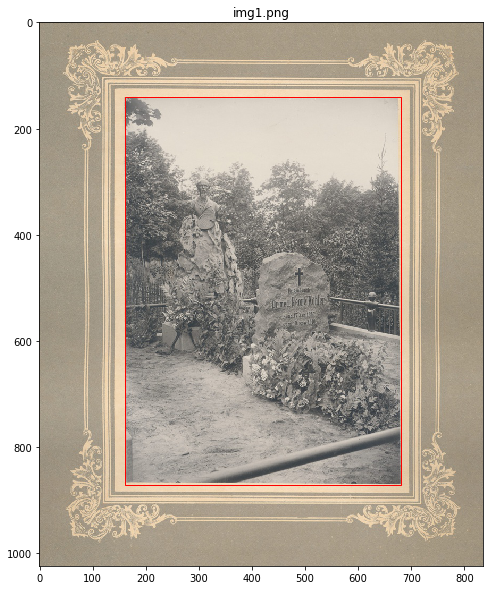

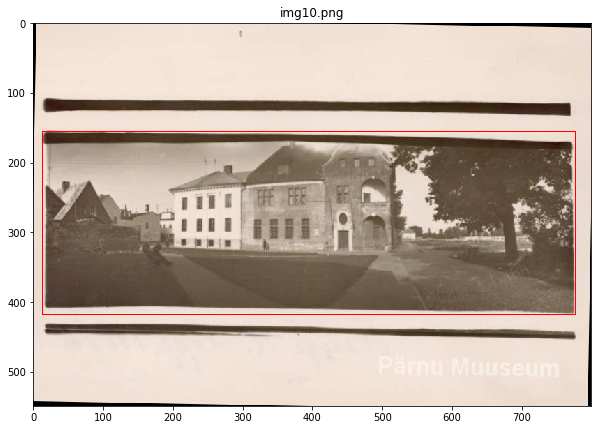

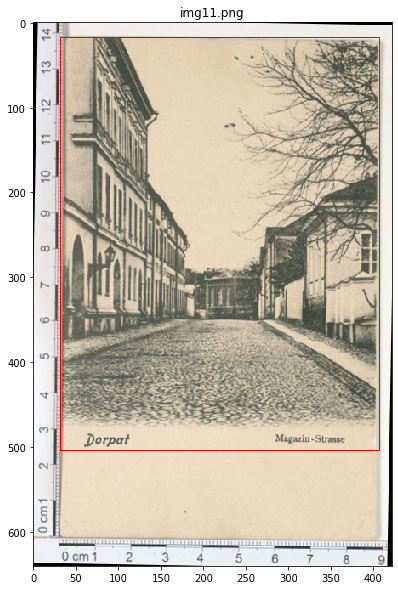

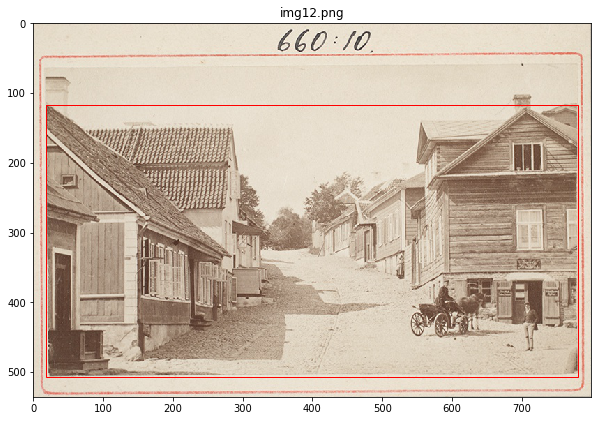

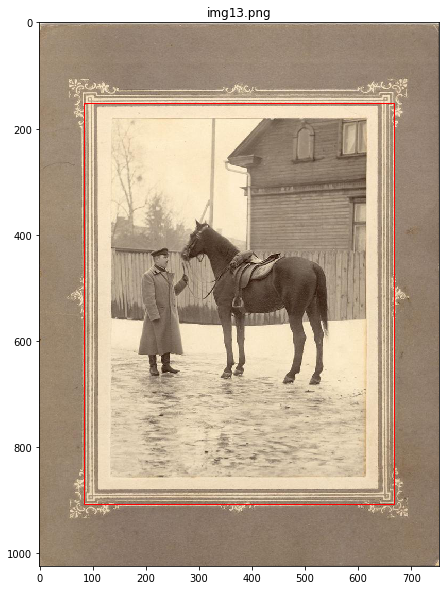

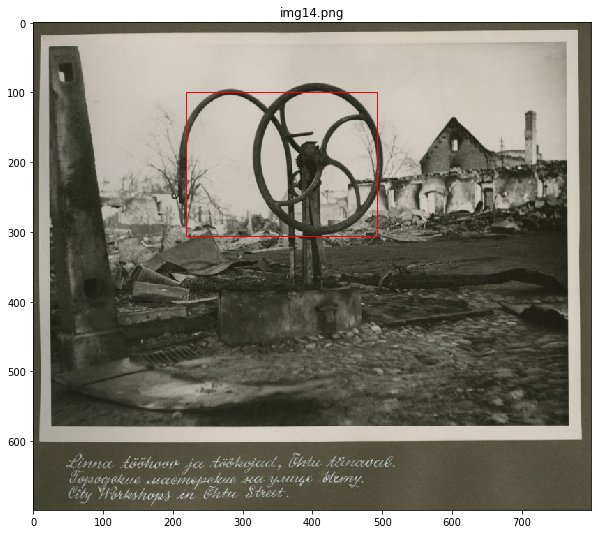

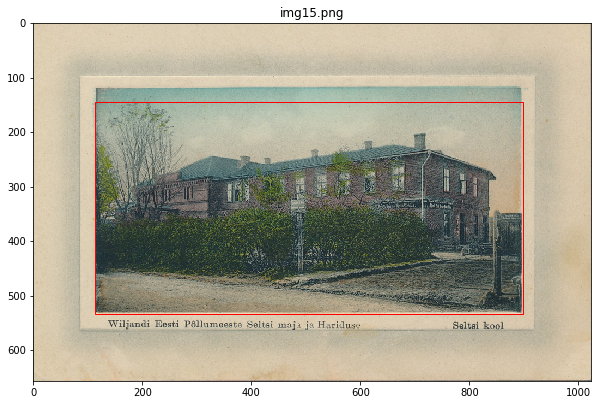

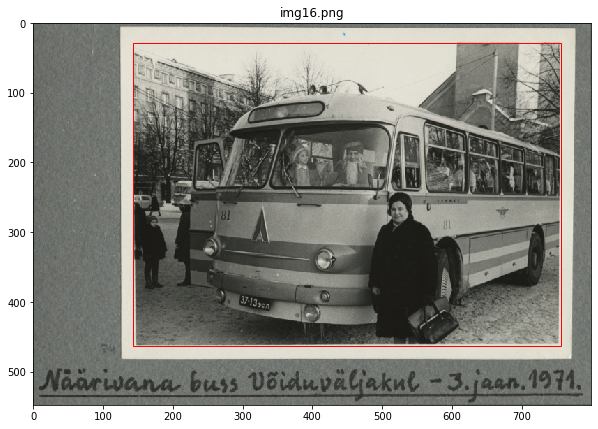

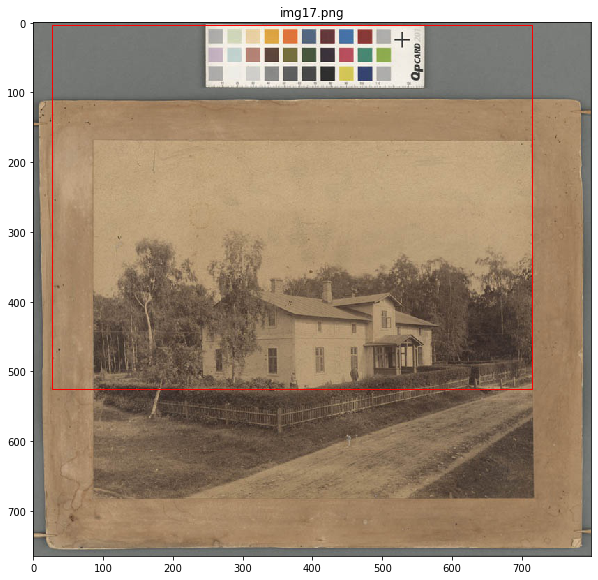

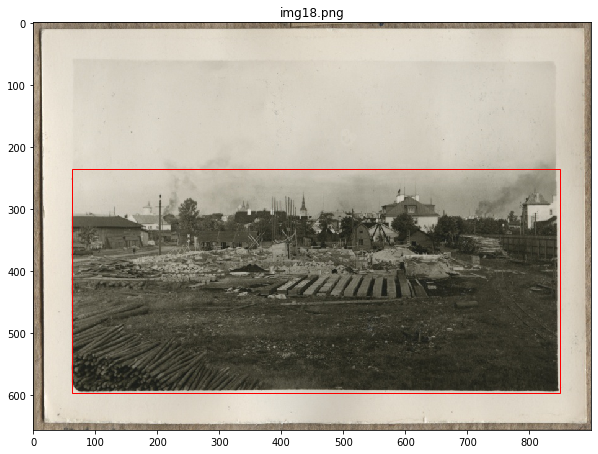

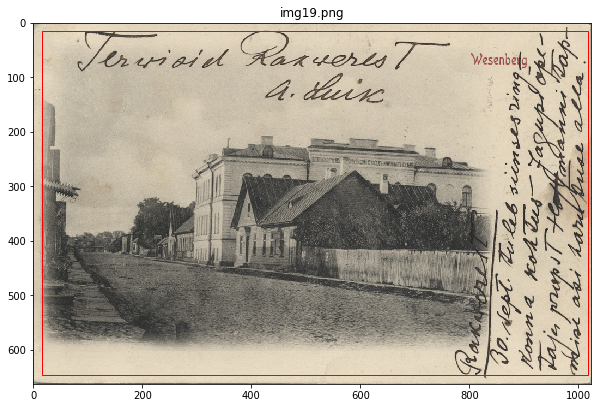

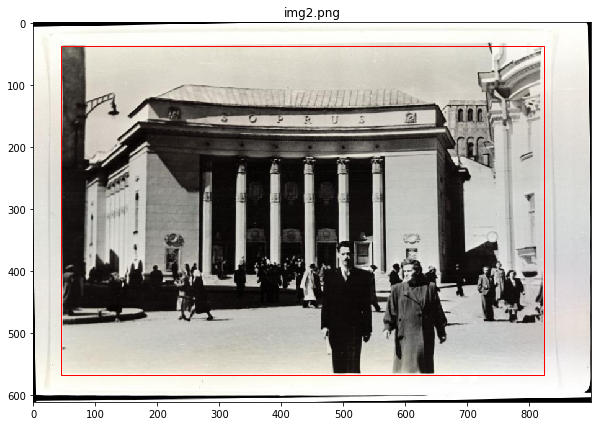

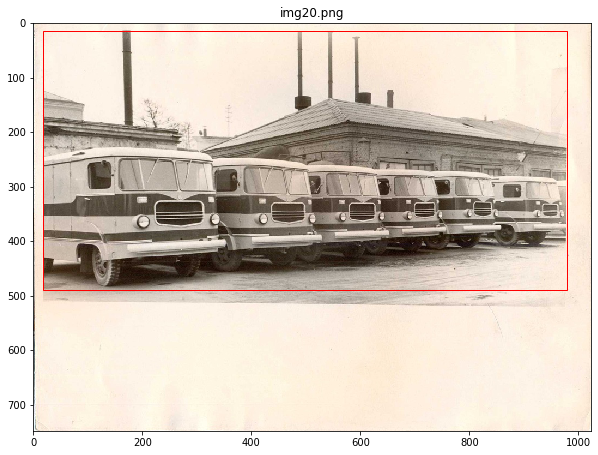

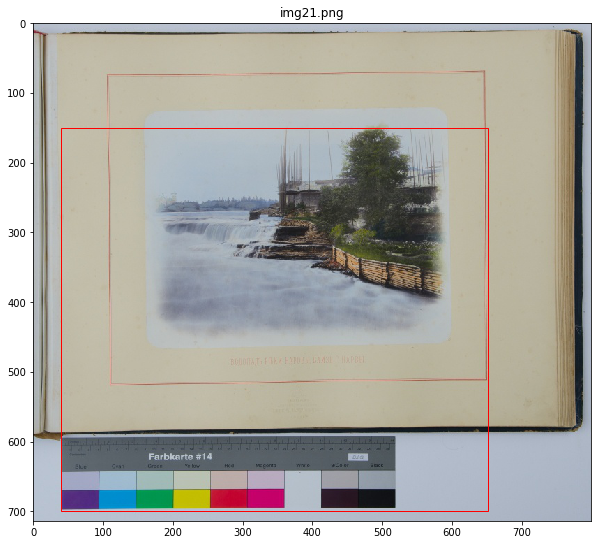

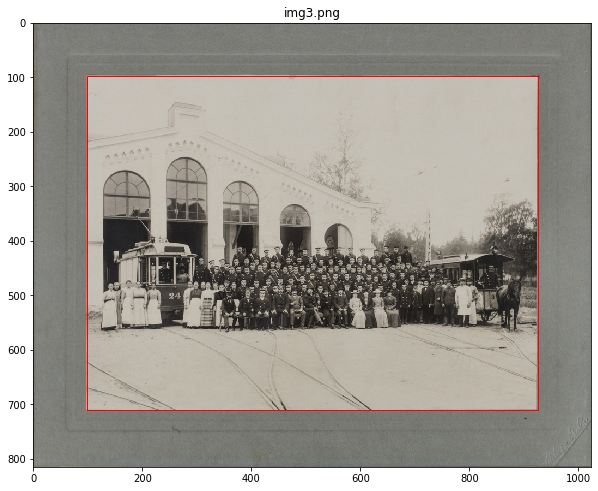

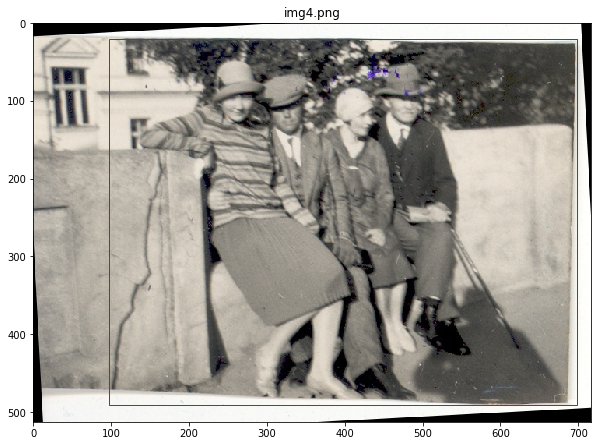

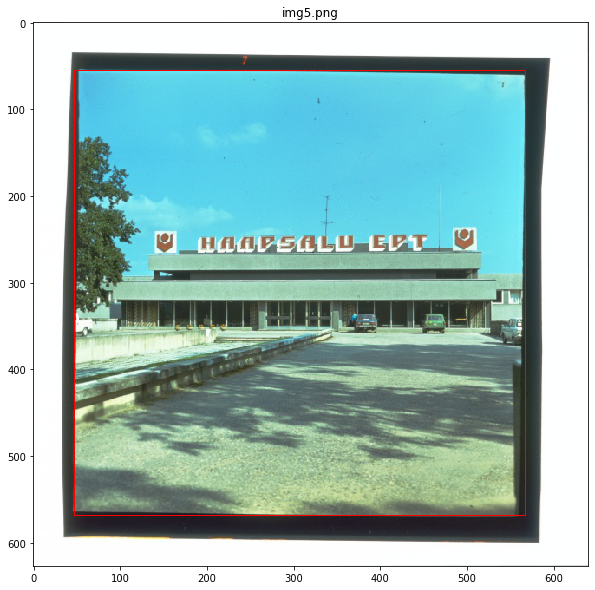

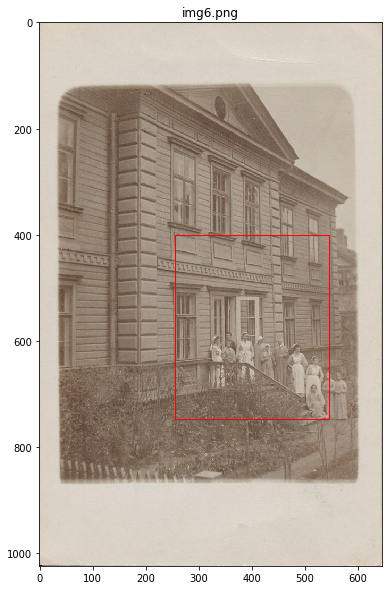

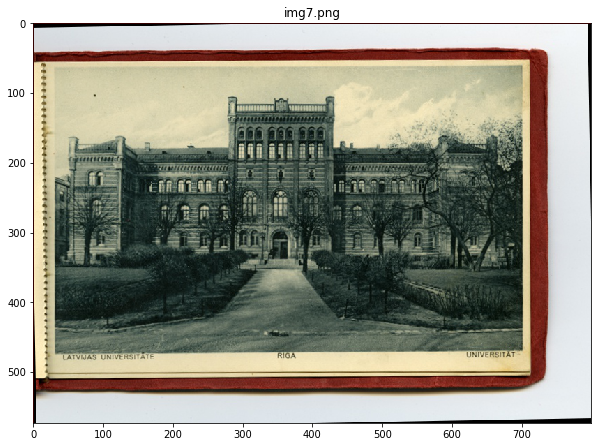

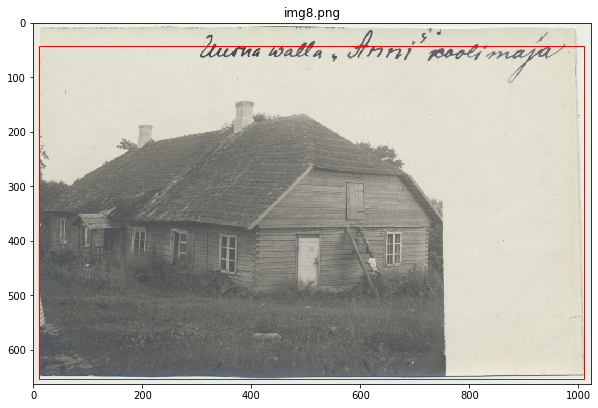

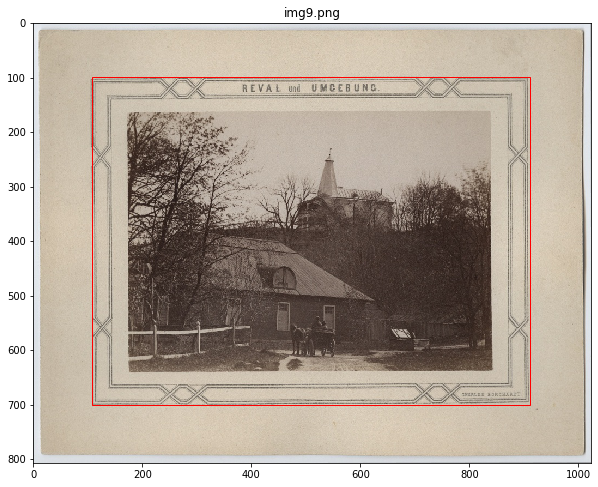

In [49]:
DEBUG_procces_all_in_directory("img", "output", False, False)
#DEBUG_procces("img/img1.png", "output", False, False)
#procces_all_in_directory("img","output")